In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import scipy.io as sio
from dataclasses import dataclass
from typing import List, Tuple
import os
from dotenv import load_dotenv
load_dotenv()
import tidy3d as td
from tidy3d import web
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from natsort import natsorted
import numpy as np
import matplotlib.animation as animation
import xarray as xr
import imageio
import matplotlib
import sys
import pandas as pd

# Assuming /AutomationModule is in the root directory of your project
sys.path.append(os.path.abspath(r'H:\phd stuff\tidy3d'))

from AutomationModule import * 

import AutomationModule as AM

In [2]:
tidy3dAPI = os.environ["API_TIDY3D_KEY"]

In [3]:
a = 1
medium = td.Medium(permittivity=11.56)
run = False

In [4]:
lambdas =  a/np.array([0.18,0.33])

In [ ]:
folder_path=rf"H:\phd stuff\tidy3d\Notebooks\20250408 gyromorphs\Structures"
project_name = fr"20250409 Transmission gyromorphs - SHU 50 x 12"
empty=False
runtime_ps = 20e-12
min_steps_per_lambda = 20
id0 = ""
add_ref = True
size_y = 12


In [6]:
data = []
for l,file in enumerate((os.listdir(folder_path))):
    print(Path(file).stem)
    data.append(pd.read_csv(os.path.join(folder_path, file)))
    print(data[l].head())
    

gyro24
          x         y
0  0.206177 -0.200403
1 -0.283969  0.097691
2  0.262358 -0.109451
3  0.467972  0.241688
4  0.004716 -0.075852
gyro60
          x         y
0  0.183443 -0.200164
1 -0.211844  0.056658
2  0.203119 -0.071596
3 -0.053299 -0.157393
4 -0.122870  0.164440


gyro24 Transmission 0.18 - 0.33
Configured successfully.


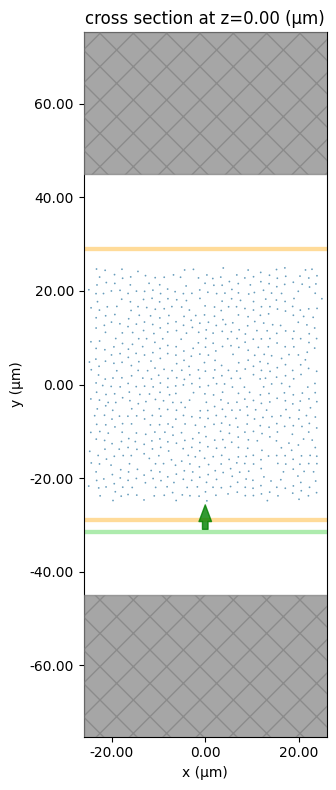

gyro60 Transmission 0.18 - 0.33
Configured successfully.


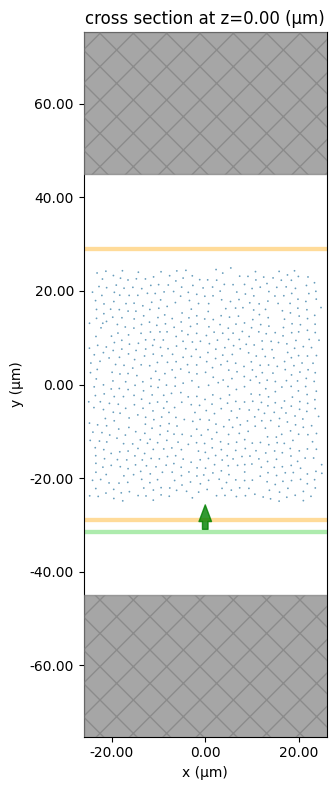

In [ ]:

for k,item in enumerate(data):
        #Tight pulse 

        run_name = f"{Path(os.listdir(folder_path)[k]).stem} Transmission {1/lambdas[0]:.3g} - {1/lambdas[1]:.3g}"
        print(run_name)
        structure_1 = AM.loadAndRunStructure(key = tidy3dAPI
                    ,direction="z", lambda_range=lambdas,
                    box_size= 50,runtime_ps=runtime_ps,min_steps_per_lambda=min_steps_per_lambda,
                   scaling=1,shuoff_condtion=1e-20, verbose=True,
                   monitors=["flux"],
                   freqs=400, 
                   source="planewave", 
                   width=0.35, ref_only=True
                   )


        sim = structure_1.sim



        boundaries= td.BoundarySpec(
                # x=td.Boundary(plus=td.Absorber(num_layers=200),minus=td.Absorber(num_layers=200)),
                y=td.Boundary(plus=td.Absorber(num_layers=200),minus=td.Absorber(num_layers=200)),
                x=td.Boundary.periodic(),
                z=td.Boundary.periodic(),
            )
        sim = sim.copy(update={'boundary_spec':boundaries})
        sim = sim.copy(update={'sources':[]})
        sim = sim.copy(update={'monitors':[]})


        Lx, Ly = 52,90
        sim = sim.copy(update={'size':[Lx,Ly,0]})

        source = td.PlaneWave(
                source_time = td.GaussianPulse(
                    freq0=structure_1.freq0,
                    fwidth=structure_1.freqw
                ),
                size= (td.inf,0,td.inf),
                center=(0,-(Lx)/2 - lambdas[0],0),
                direction='+',
                pol_angle=np.pi/2,
                name='planewave',
                )

        sim = sim.copy(update={'sources':[source]})

      
        monitor_1 = td.FluxMonitor(
                center = (
                                0,-((Lx)/2+3),0
                                ),
                size = (
                   td.inf,0,td.inf
                    ),
                freqs = structure_1.monitor_freqs,
                name='flux2' )

        monitor_2 = td.FluxMonitor(
                center = (
                                0,(Lx)/2+3,0
                                ),
                size = (
                   td.inf,0,td.inf
                    ),
                freqs = structure_1.monitor_freqs,
                name='flux1' 
            )

        sim = sim.copy(update={'monitors':[monitor_1,monitor_2]})

        cyl_group = []
        for x, y in zip(data[k]['x'], data[k]['y']):
            x,y = x*50,y*50
            if np.abs(y)<=(Lx/2):
                cyl_group.append(td.Cylinder(center=[x, y, 0], radius=0.189, length=td.inf))

        cylinders = td.Structure(geometry=td.GeometryGroup(geometries=cyl_group), medium=medium)


        if empty:
            sim = sim.copy(update={'structures':[],"grid_spec": td.GridSpec.uniform(dl=structure_1.dl)})
        else:
            sim = sim.copy(update={'structures':[cylinders],"grid_spec": td.GridSpec.uniform(dl=structure_1.dl)})

        sim_name = run_name
        fig, ax = plt.subplots(1, tight_layout=True, figsize=(16, 8))
        sim.plot(z=0, ax=ax)
        plt.show()

        # if run:
        #     if add_ref:
        #          id0 =web.upload(sim.copy(update={'structures':[]}), folder_name=project_name,task_name=fr"{sim_name}_0", verbose=True)
        #          web.start(task_id = id0)
        #          web.monitor(task_id=id0,verbose=True)
        #          add_ref = False

        #     id =web.upload(sim, folder_name=project_name,task_name=sim_name, verbose=True)
        #     web.start(task_id = id)
        #     web.monitor(task_id=id,verbose=True)
        #     ids = id0+ '\n' + id
        #     structure_folder =Path(os.listdir(folder_path)[k]).stem
        #     file_path = rf"H:\phd stuff\tidy3d\data/{project_name}/{structure_folder}/{sim_name}.txt"
        #     # Check if the folder exists
        #     if not os.path.exists( fr"H:\phd stuff\tidy3d\data/{project_name}/{structure_folder}"):
        #         os.makedirs(fr"H:\phd stuff\tidy3d\data/{project_name}/{structure_folder}")
        #         print(fr"Folder 'H:\phd stuff\tidy3d\data/{project_name}/{structure_folder}' created successfully.")

        #     # Open file in write mode
        #     with open(file_path, "w") as f:
        #         # Write the string to the file
        #         f.write(ids)
        # else:
        #     sim.plot_3d()
        #     id =web.upload(sim,task_name=sim_name, verbose=True)
        #     print(web.estimate_cost(id))
        #     raise TypeError("Program ends here")

